In [38]:
# @title ResNet
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout2d(p=dropout_rate)  # Dropout між шарами

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Застосування Dropout після першого шару
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.3):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout перед повнозв'язним шаром
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.global_pool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)  # Dropout перед фінальним шаром
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], dropout_rate=0.3)


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3], dropout_rate=0.3)


Files already downloaded and verified
Files already downloaded and verified


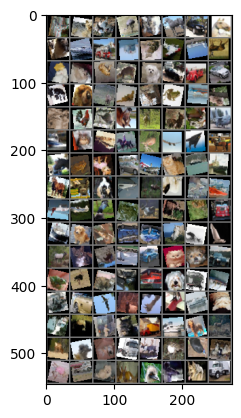

deer dog horse bird cat horse automobile horse


In [48]:
# @title Datasets
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2,
    #                        contrast=0.2,
    #                        saturation=0.2,
    #                        hue=0.1),
    # transforms.RandomGrayscale(p=0.1),
    # transforms.GaussianBlur(kernel_size=(3, 3),
    #                         sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33),
    #                          ratio=(0.3, 3.3),
    #                          value='random')
])


train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = train_dataset.dataset.classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(8)))


In [13]:
# @title Early Stopping
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [40]:
# @title Train Model
from tqdm import tqdm

def train_model(net, device, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=30, patience=2):
    # print(net)
    print(device)

    net.to(device)

    train_losses, val_losses = [], []

    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model.pth')

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        net.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        early_stopping(val_losses[-1], net)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        scheduler.step()

    net.load_state_dict(torch.load('best_model.pth'))

    return train_losses, val_losses


In [49]:
# @title Train Script
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

net = ResNet34()
net=nn.DataParallel(net)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 20
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.005,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs
)

train_losses, val_losses = train_model(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=num_epochs
)

print(train_losses, val_losses)

cuda


Epoch 1/20: 100%|██████████| 313/313 [00:25<00:00, 12.36it/s]


Epoch 1: Train Loss = 2.1168, Val Loss = 1.9327
Validation loss decreased (inf --> 1.932721). Saving model ...


Epoch 2/20: 100%|██████████| 313/313 [00:28<00:00, 10.96it/s]


Epoch 2: Train Loss = 1.8619, Val Loss = 1.7306
Validation loss decreased (1.932721 --> 1.730583). Saving model ...


Epoch 3/20: 100%|██████████| 313/313 [00:28<00:00, 10.95it/s]


Epoch 3: Train Loss = 1.7462, Val Loss = 1.6157
Validation loss decreased (1.730583 --> 1.615683). Saving model ...


Epoch 4/20: 100%|██████████| 313/313 [00:25<00:00, 12.16it/s]


Epoch 4: Train Loss = 1.6532, Val Loss = 1.5517
Validation loss decreased (1.615683 --> 1.551651). Saving model ...


Epoch 5/20: 100%|██████████| 313/313 [00:27<00:00, 11.35it/s]


Epoch 5: Train Loss = 1.5822, Val Loss = 1.4808
Validation loss decreased (1.551651 --> 1.480786). Saving model ...


Epoch 6/20: 100%|██████████| 313/313 [00:27<00:00, 11.52it/s]


Epoch 6: Train Loss = 1.5118, Val Loss = 1.3833
Validation loss decreased (1.480786 --> 1.383330). Saving model ...


Epoch 7/20: 100%|██████████| 313/313 [00:28<00:00, 11.03it/s]


Epoch 7: Train Loss = 1.4584, Val Loss = 1.3556
Validation loss decreased (1.383330 --> 1.355561). Saving model ...


Epoch 8/20: 100%|██████████| 313/313 [00:27<00:00, 11.30it/s]


Epoch 8: Train Loss = 1.4055, Val Loss = 1.3093
Validation loss decreased (1.355561 --> 1.309338). Saving model ...


Epoch 9/20: 100%|██████████| 313/313 [00:27<00:00, 11.31it/s]


Epoch 9: Train Loss = 1.3679, Val Loss = 1.2598
Validation loss decreased (1.309338 --> 1.259777). Saving model ...


Epoch 10/20: 100%|██████████| 313/313 [00:26<00:00, 11.62it/s]


Epoch 10: Train Loss = 1.3270, Val Loss = 1.2334
Validation loss decreased (1.259777 --> 1.233429). Saving model ...


Epoch 11/20: 100%|██████████| 313/313 [00:29<00:00, 10.70it/s]


Epoch 11: Train Loss = 1.2989, Val Loss = 1.2029
Validation loss decreased (1.233429 --> 1.202870). Saving model ...


Epoch 12/20: 100%|██████████| 313/313 [00:28<00:00, 10.83it/s]


Epoch 12: Train Loss = 1.2597, Val Loss = 1.1815
Validation loss decreased (1.202870 --> 1.181519). Saving model ...


Epoch 13/20: 100%|██████████| 313/313 [00:29<00:00, 10.64it/s]


Epoch 13: Train Loss = 1.2341, Val Loss = 1.1427
Validation loss decreased (1.181519 --> 1.142749). Saving model ...


Epoch 14/20: 100%|██████████| 313/313 [00:30<00:00, 10.25it/s]


Epoch 14: Train Loss = 1.2077, Val Loss = 1.1264
Validation loss decreased (1.142749 --> 1.126390). Saving model ...


Epoch 15/20: 100%|██████████| 313/313 [00:26<00:00, 11.64it/s]


Epoch 15: Train Loss = 1.1915, Val Loss = 1.0942
Validation loss decreased (1.126390 --> 1.094240). Saving model ...


Epoch 16/20: 100%|██████████| 313/313 [00:27<00:00, 11.27it/s]


Epoch 16: Train Loss = 1.1635, Val Loss = 1.1011
EarlyStopping counter: 1 out of 2


Epoch 17/20: 100%|██████████| 313/313 [00:26<00:00, 11.60it/s]


Epoch 17: Train Loss = 1.1466, Val Loss = 1.0534
Validation loss decreased (1.094240 --> 1.053440). Saving model ...


Epoch 18/20: 100%|██████████| 313/313 [00:28<00:00, 11.16it/s]


Epoch 18: Train Loss = 1.1231, Val Loss = 1.0461
Validation loss decreased (1.053440 --> 1.046113). Saving model ...


Epoch 19/20: 100%|██████████| 313/313 [00:25<00:00, 12.08it/s]


Epoch 19: Train Loss = 1.1143, Val Loss = 1.0375
Validation loss decreased (1.046113 --> 1.037502). Saving model ...


Epoch 20/20: 100%|██████████| 313/313 [00:28<00:00, 10.91it/s]


Epoch 20: Train Loss = 1.0934, Val Loss = 1.0222
Validation loss decreased (1.037502 --> 1.022167). Saving model ...
[2.116801399773302, 1.8618993290697043, 1.7462487574964285, 1.6532463387559397, 1.582232953260501, 1.5117810633235846, 1.4583769290211102, 1.4054960766539406, 1.3679372049368228, 1.3270093568216879, 1.2989293481595219, 1.2597486908062578, 1.2340835157674723, 1.2077027003224285, 1.1915173279210782, 1.1635058453669562, 1.1465656085136218, 1.1231373618966856, 1.1143292706614485, 1.0933925579911985] [1.9327206958698322, 1.7305829072300392, 1.6156828841076623, 1.5516514808316775, 1.4807857938959628, 1.3833296012274827, 1.355561081367203, 1.309338387054733, 1.2597768201103694, 1.233429158790202, 1.20286977442005, 1.181519073776052, 1.1427488862713682, 1.1263898950588853, 1.0942400527905813, 1.1011291063284572, 1.0534404252148881, 1.0461126656471929, 1.0375023944468438, 1.022167314456988]


<ipython-input-40-ac014c5d1438>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


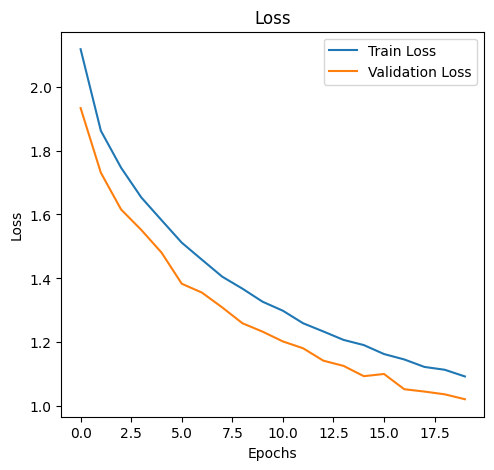

In [50]:
# @title Train diagram
# Графіки втрат
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [51]:
# @title Test script
import os
if os.path.exists("best_model.pth"):
    net.load_state_dict(torch.load("best_model.pth"))
else:
    print("Model file not found!")
    exit()

net.eval()
test_loss = 0.0
correct = 0
total = 0
num_classes = 10
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

test_loss /= total
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

for i in range(num_classes):
    if class_total[i] > 0:
        print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Accuracy of class {i}: No samples")


<ipython-input-51-25f3318e4fa7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


Test Loss: 1.0451, Test Accuracy: 75.50%
Accuracy of class 0: 77.20%
Accuracy of class 1: 90.60%
Accuracy of class 2: 67.60%
Accuracy of class 3: 57.50%
Accuracy of class 4: 70.10%
Accuracy of class 5: 59.70%
Accuracy of class 6: 87.30%
Accuracy of class 7: 72.70%
Accuracy of class 8: 88.30%
Accuracy of class 9: 84.00%
